In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

# Information about the test

In this test, the `requests` datasets contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request. The `individuals` datasets contains information about each individual for all requests.
You can use the column `request_id` to link the two datasets.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `requests_train`, the predictions should be made for requests listed in the `requests_test` dataset. The competition score should also be computed on the `requests_test`.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

The score for a random prediction is shown at the end of this notebook (~1.6), your trained models should at least reach a **score below 1** to be significantly better.

Good luck!

## Data description

### File requests_train.csv

| Field name                       | Description                                                                                                                                                        | Type                     |
|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                      | "the id of request, which is unique in this dataset\."                                                                                                             | string                   |
| animal\_presence                 | flage indicating whether an animal is accompanying the group                                                                                                       | boolean                  |
| answer\_creation\_date           | the timestamp when the anwer was registered                                                                                                                        | timestamp \(iso format\) |
| child\_situation                 | the number representing the situation of the children in the group \(if any\)                                                                                      | integer                  |
| child\_to\_come                  | flag indicating whether the group is expecting a baby                                                                                                              | boolean                  |
| district                         | the id of the administrative district where the request is made\. Each district has its own emergency center responsible for receiving and managing the requests\. | integer                  |
| granted\_number\_of\_nights      | "the target \(train dataset only\), the categorized number of nights granted to the request"                                                                       | integer                  |
| group\_composition\_id           | the number representing the group composition                                                                                                                      | integer                  |
| group\_composition\_label        | the description of the group composition                                                                                                                           | string                   |
| group\_creation\_date            | the timestamp when the group was created in the database                                                                                                           | timestamp \(iso format\) |
| group\_id                        | "the id of the group\. A group can be linked to several requests, so not unique"                                                                                   | string                   |
| group\_main\_requester\_id       | the id of the individual making the request\. it cannot be joined with individual\_id                                                                              | string                   |
| group\_type                      | whether the group is a made of several people \(GROUP\) or just one person \(PERSON\)                                                                              | string                   |
| housing\_situation\_id           | the id of the housing situation of the group when making the request                                                                                               | integer                  |
| housing\_situation\_label        | the description of the housing situation of the group when making the request                                                                                      | string                   |
| long\_term\_housing\_request     | flag indicating whether the groupe has filed a request for a long term housing solution\.                                                                          | boolean                  |
| number\_of\_underage             | the number of individual under 18 in the group                                                                                                                     | integer                  |
| request\_backoffice\_creator\_id | the id of the emergency call center employee who received the request                                                                                              | string                   |
| request\_creation\_date          | the timestamp when the request was made\.                                                                                                                          | timestamp \(iso format\) |
| requester\_type                  | the type of person who called the emergency service \(a user / a social patrol / a third party\)                                                                   | string                   |
| social\_situation\_id            | the id representing the social situation of the group in the database                                                                                              | string                   |
| town                             | the town where the requester is living                                                                                                                             | string                   |
| victim\_of\_violence             | flag indicating whether the group includes an individual victim of violence                                                                                        | boolean                  |
| victim\_of\_violence\_type       | type of the individual victim of violence \(and if it is a case of domestic violence\)                                                                             | string                   |


In [4]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

C:\Users\user\AppData\Local\Temp\ipykernel_14368\1703234402.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
C:\Users\user\AppData\Local\Temp\ipykernel_14368\1703234402.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',


,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


### File individuals_train.csv

| Field name                      | Description                                                                                                               | Type                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                     | the id of the request\. It is not unique in this dataset \(a request can be for several individual in case of a group\)\. | string                   |
| individual\_id                  | the id of the individual                                                                                                  | string                   |
| birth\_month                    | month of birth of the individual                                                                                          | integer                  |
| birth\_year                     | the year of birth of the individual                                                                                       | integer                  |
| childcare\_center\_supervision  | flag representing the fact that a child receives follow\-up care                                                          | boolean                  |
| disabled\_worker\_certification | flag representing the fact that an individual is considered disabled regarding the employement law                        | boolean                  |
| gender                          | the gender of the individual                                                                                              | boolean                  |
| housing\_situation\_2\_id       | housing situation category number of the group when making the request \(more precise\)                                   | integer                  |
| housing\_situation\_2\_label    | description of the housing situation of the group when making the request \(more precise\)                                | string                   |
| individual\_creation\_date      | timestamp of the individual creation in the database                                                                      | timestamp \(iso format\) |
| individual\_role                | description of the role of the individual                                                                                 | string                   |
| individual\_role\_2\_id         | category number of the role of the individual                                                                             | integer                  |
| individual\_role\_2\_label      | "description of the role of the individual, more precise than the former"                                                 | string                   |
| marital\_status\_id             | id of the marital status of the individual                                                                                | integer                  |
| marital\_status\_label          | description of the marital status of the individual                                                                       | string                   |
| pregnancy                       | flag representing whether the individual is pregnant \(if applicable\)                                                    | boolean                  |


# 2- Load the datasets

In [5]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

C:\Users\user\AppData\Local\Temp\ipykernel_14368\2751533235.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
C:\Users\user\AppData\Local\Temp\ipykernel_14368\2751533235.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',


,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


In [7]:
# Train sample
requests_train = pd.read_csv('data/requests_train.csv', sep=',', low_memory=False, error_bad_lines=False)

# Test sample
requests_test = pd.read_csv('data/requests_test.csv', sep=',', low_memory=False, error_bad_lines=False)

C:\Users\user\AppData\Local\Temp\ipykernel_14368\2586954981.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  requests_train = pd.read_csv('data/requests_train.csv', sep=',', low_memory=False, error_bad_lines=False)
C:\Users\user\AppData\Local\Temp\ipykernel_14368\2586954981.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  requests_test = pd.read_csv('data/requests_test.csv', sep=',', low_memory=False, error_bad_lines=False)


In [8]:
# Inspect basic metadata about the dataset
print(requests_train.info())
print(requests_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238191 entries, 0 to 238190
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   request_id                     238191 non-null  object
 1   animal_presence                238191 non-null  object
 2   answer_creation_date           238191 non-null  object
 3   child_situation                238191 non-null  int64 
 4   child_to_come                  92244 non-null   object
 5   district                       238191 non-null  int64 
 6   granted_number_of_nights       238191 non-null  int64 
 7   group_composition_id           238191 non-null  int64 
 8   group_composition_label        238191 non-null  object
 9   group_creation_date            238191 non-null  object
 10  group_id                       238191 non-null  object
 11  group_main_requester_id        238191 non-null  object
 12  group_type                     238191 non-nu

# 3- Distribution of the target

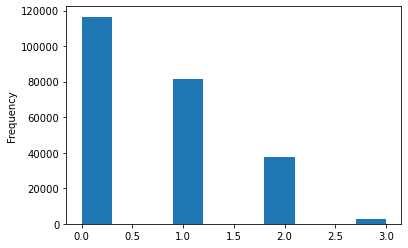

In [9]:
# histogram of the target variable
requests_train['granted_number_of_nights'].plot.hist()
None
#print(requests.head())

# 4-Train and evaluate a first model

In [10]:
# selected columns for explanatory variable
columns = ['animal_presence', 'answer_creation_date', 'child_situation',
           'child_to_come', 'district',
           'group_composition_label', 'group_creation_date',
           'group_type','housing_situation_id',
           'long_term_housing_request', 'number_of_underage',
           'request_creation_date',
           'requester_type', 'town',
           'victim_of_violence', 'victim_of_violence_type']

X = requests_train[columns]
y = requests_train['granted_number_of_nights']
X_length = len(X)
X_test = requests_test[columns]

all_dataset = pd.concat([X, X_test], sort=False)
#print(all_dataset.iloc[:X_length].tail())

In [11]:
def pre_process(X):
    X = X.fillna('12123')
    return X

In [12]:
oenc = OrdinalEncoder()
#oenc = OneHotEncoder(sparse=True)
benc = OneHotEncoder(sparse=False)

category_col = ['district', 'group_type', 'housing_situation_id', 'long_term_housing_request',
         'requester_type', 'town']
bool_cols = ['animal_presence', 'child_to_come', 'animal_presence', 'group_composition_label', 'victim_of_violence', 'victim_of_violence_type']
other_cols = ['child_situation', 'number_of_underage']

all_dataset = pre_process(all_dataset)
cat = all_dataset[category_col]
boo = all_dataset[bool_cols]
other = all_dataset[other_cols]

oenc.fit(cat)
benc.fit(boo)
print(oenc.transform(cat).shape)
cat = oenc.transform(cat)

print(benc.transform(boo).shape)
boo = benc.transform(boo)
other = other.values

print(cat.shape)
print(boo.shape)
print(other.shape)
data = np.concatenate((boo, cat, other), axis=1)
all_dataset = data

(297739, 6)
(297739, 30)
(297739, 6)
(297739, 30)
(297739, 2)


In [13]:
print(all_dataset[:X_length].shape)
#print(y)

(238191, 38)


In [14]:
data

array([[  1.,   0.,   1., ...,   0.,  -1.,  -1.],
       [  1.,   0.,   1., ...,   0.,  -1.,  -1.],
       [  1.,   0.,   1., ...,   0.,  -1.,  -1.],
       ...,
       [  1.,   0.,   0., ..., 217.,  -1.,   0.],
       [  1.,   0.,   0., ..., 301.,  -1.,  -1.],
       [  1.,   0.,   0., ...,   0.,  -1.,   1.]])

In [15]:
# split between the train and the validation samples
X = all_dataset[:X_length]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [16]:
model = RandomForestClassifier(n_estimators=10, min_samples_split=15, max_depth=10, max_features=20, class_weight={0: 1, 1: 10, 2: 100, 3: 1000}, random_state=42)
#model = LogisticRegression(C=1.0, solver='newton-cg', penalty='none', multi_class='multinomial',max_iter=200, class_weight={0: 1, 1: 10, 2: 100, 3: 1000}, verbose=10)
print(model)
#model = DecisionTreeClassifier(class_weight={0: 1, 1: 10, 2: 100, 3: 1000})

RandomForestClassifier(class_weight={0: 1, 1: 10, 2: 100, 3: 1000},
                       max_depth=10, max_features=20, min_samples_split=15,
                       n_estimators=10, random_state=42)


In [18]:
# fit the model
#model.fit(X_train, y_train)
model.fit(X, y)

RandomForestClassifier(class_weight={0: 1, 1: 10, 2: 100, 3: 1000},
                       max_depth=10, max_features=20, min_samples_split=15,
                       n_estimators=10, random_state=42)

In [19]:
# evaluate the model with the competition scorer (validation set)
print(competition_scorer(y_val, model.predict_proba(X_val)))

0.6258000349867596


In [20]:

model.classes_

array([0, 1, 2, 3], dtype=int64)

# 5- Compute predictions on the test set

In [21]:
# use the model to predict on the test set
X_test = all_dataset[X_length:]
y_pred = model.predict_proba(X_test)

In [22]:
# overview of prediction probabilities for first four rows
y_pred[:4]

array([[0.06955209, 0.08155313, 0.32026035, 0.52863443],
       [0.04166356, 0.09785287, 0.50155748, 0.35892609],
       [0.1996682 , 0.17539456, 0.62493724, 0.        ],
       [0.0302065 , 0.1366399 , 0.32527055, 0.50788304]])

In [23]:
predictions = pd.concat([requests_test['request_id'], pd.DataFrame(y_pred)], axis=1)

# 6- Submit your predictions to the QScore platform

In [24]:
import io, math, requests

# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='ddb80cdfd01cc72a553168352c66b2232c943d0e6c91241187cc0e007fe29777a4c8af8d0c1e3689e768ca0029d7e055afeb4ff55f9d8cd5128729cc9829cc5d'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [26]:
submit_prediction(predictions, sep=',', index=False, comment='my submission')

ConnectionError: HTTPSConnectionPool(host='qscore.datascience-olympics.com', port=443): Max retries exceeded with url: /api/submissions (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000026D84764F40>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

# Evaluation

In [5]:
#random_preds = np.random.uniform(size=(requests_test.shape[0], 4))
#y_true = requests_test.granted_number_of_nights.values
#random_score = competition_scorer(y_true, random_preds)

#print(f'test score: {random_score}')

test score: 1.6465241024382162
